

# Imports



In [1]:
import json
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense

2025-07-13 17:50:05.787056: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 17:50:05.788390: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 17:50:05.793592: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 17:50:05.805373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752429005.824003    6697 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752429005.82

# Class and POA func

In [2]:
# Class
import pvlib

class PVPark:
    def __init__(self, name, latitude, longitude, altitude, tz, tilt, azimuth, nominal_capacity):
        self.location = pvlib.location.Location(latitude=latitude, longitude=longitude, altitude=altitude, tz=tz, name=name)
        self.tilt = tilt
        self.azimuth = azimuth
        self.nominal_capacity = nominal_capacity

    @classmethod
    def from_dataframe(cls, df, index=0):
        row = df.iloc[index]

        lat = row['latitude']
        azimuth = row['azimuth'] if pd.notnull(row['azimuth']) else 180.0
        tilt = row['tilt'] if pd.notnull(row['tilt']) else lat
        altitude = row['altitude'] if pd.notnull(row['altitude']) else None

        return cls(
            name=row['name'],
            latitude=lat,
            longitude=row['longitude'],
            altitude=altitude,
            tz=row['tz'],
            tilt=tilt,
            azimuth=azimuth,
            nominal_capacity=row['nominal_capacity']
        )

In [3]:
def get_poa(df, park):
    # Full time index in global time
    times = df['collect_time']
    times = pd.to_datetime(times).dt.tz_localize(pv_park.location.tz, ambiguous=False, nonexistent='NaT')
    times = pd.to_datetime(times)

    # Get solar position
    solpos = park.location.get_solarposition(times)

    # GHI time series
    ghi = df['irradiance'].astype(np.float32).values
    ghi = pd.Series(ghi, index=times)

    # Estimate DHI and DNI for the full time range
    dhi = pvlib.irradiance.erbs(ghi, solpos['zenith'], ghi.index)['dhi']
    dni = pvlib.irradiance.dni(ghi, dhi, solpos['zenith'])

    # Calculate POA for all time steps
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=park.tilt,
        surface_azimuth=park.azimuth,
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        solar_zenith=solpos['zenith'],
        solar_azimuth=solpos['azimuth']
    )

    # Mask nighttime: set poa_global to 0 when sun is below horizon
    poa.loc[solpos['zenith'] >= 90, ['poa_global', 'poa_direct', 'poa_diffuse']] = 0
    poa = poa.reset_index(drop=True)

    df['poa_global'] = poa['poa_global']
    df.drop(['irradiance'], axis=1, inplace=True)
    df = df.fillna(0)

    return df

# Load  Training Data

## Load metadata and create park info

In [4]:
base_dir="/home/jovyan/work/pv-digital-twin"

In [5]:
df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/metadata.csv")
# Create PVPark instance from DataFrame
pv_park = PVPark.from_dataframe(df)
print(pv_park.location)
print(pv_park.tilt)
print(pv_park.azimuth)

Location: 
  name: Gasi-CN448
  latitude: 35.13
  longitude: 25.259
  altitude: 334.0
  tz: Europe/Athens
25.0
180.0


## Load data

In [6]:
df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/data.csv")

print(df.head())
print(len(df)/288)

          collect_time  temperature  irradiance  wind_speed  active_power
0  2023-08-12 00:00:00         20.6         0.0         8.5           0.0
1  2023-08-12 00:05:00         20.6         0.0         8.5           0.0
2  2023-08-12 00:10:00         20.6         0.0         8.5           0.0
3  2023-08-12 00:15:00         20.6         0.0         8.5           0.0
4  2023-08-12 00:20:00         20.6         0.0         8.5           0.0
539.0


## Calculate poa

In [7]:
df = get_poa(df, pv_park)

print(df.head())
print(len(df)/288)

          collect_time  temperature  wind_speed  active_power  poa_global
0  2023-08-12 00:00:00         20.6         8.5           0.0         0.0
1  2023-08-12 00:05:00         20.6         8.5           0.0         0.0
2  2023-08-12 00:10:00         20.6         8.5           0.0         0.0
3  2023-08-12 00:15:00         20.6         8.5           0.0         0.0
4  2023-08-12 00:20:00         20.6         8.5           0.0         0.0
539.0


# Scale Data and Create Train, Validation Dataset

In [8]:
# Scale all features
features = ['temperature', 'wind_speed', 'poa_global']
target = 'active_power'

scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

df[features] = scaler_x.fit_transform(df[features])
# Scale and clip the target at 1.0
df[target] = (df[target] / pv_park.nominal_capacity).clip(upper=1.0)

print(df.head())
print(len(df)/288)

          collect_time  temperature  wind_speed  active_power  poa_global
0  2023-08-12 00:00:00          0.5    0.278689           0.0         0.0
1  2023-08-12 00:05:00          0.5    0.278689           0.0         0.0
2  2023-08-12 00:10:00          0.5    0.278689           0.0         0.0
3  2023-08-12 00:15:00          0.5    0.278689           0.0         0.0
4  2023-08-12 00:20:00          0.5    0.278689           0.0         0.0
539.0


In [9]:
def create_aligned_sequences(data, features, target, input_len=144):
    X, y = [], []
    for i in range(0, len(data), input_len):
        x_seq = data[features].iloc[i:i+input_len].values
        y_seq = data[target].iloc[i:i+input_len].values
        X.append(x_seq)
        y.append(y_seq)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_aligned_sequences(df, features, target, input_len=288)

In [10]:
print("X:", X.shape)  # (samples, 288, 3)
print("y:", y.shape)  # (samples, 288)

X: (539, 288, 3)
y: (539, 288)


In [11]:
print("NaNs in X", np.isnan(X).sum())
print("NaNs in y:", np.isnan(y).sum())

NaNs in X 0
NaNs in y: 0


# The Model

In [12]:
def build_bilstm_model(input_shape, output_len=288):
    inputs = Input(shape=input_shape)  # (time_steps, features)

    x = Bidirectional(LSTM(64, return_sequences=False))(inputs)  # No sequence output

    output = Dense(output_len)(x)

    model = Model(inputs=inputs, outputs=output)
    return model

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

y_train = np.clip(y_train, 0.0, 1.0)
y_val = np.clip(y_val, 0.0, 1.0)

print("X_train:", X_train.shape)  # (samples, 288, 3)
print("y_train:", y_train.shape)  # (samples, 288)

input_shape = (288, 3)
output_len = 288
model = build_bilstm_model(input_shape=input_shape, output_len=output_len)
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

X_train: (431, 288, 3)
y_train: (431, 288)
Epoch 1/20


2025-07-13 17:50:06.106571: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 0.1108 - val_loss: 0.0484
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0388 - val_loss: 0.0246
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0217 - val_loss: 0.0222
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0202 - val_loss: 0.0211
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0193 - val_loss: 0.0212
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0194 - val_loss: 0.0210
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0188 - val_loss: 0.0208
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0181 - val_loss: 0.0212
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0192 - val_loss: 0.0203
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0174 - val_loss: 0.0202
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.0183 - val_loss: 0.0197
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.

# Validate

## Metrics

In [14]:
y_pred = model.predict(X_val)  # shape: (num_samples, 288)

# Inverse scale
y_val_inv = y_val * pv_park.nominal_capacity
y_pred_inv = y_pred * pv_park.nominal_capacity

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


In [15]:
# Save evaluation metrics
metrics = {
    "validation": {
        "r2": float(r2_score(y_val_inv.flatten(), y_pred_inv.flatten())),
        "rmse": float(np.sqrt(mean_squared_error(y_val_inv.flatten(), y_pred_inv.flatten()))),
        "mae": float(mean_absolute_error(y_val_inv.flatten(), y_pred_inv.flatten())),
    }
}

print(metrics)

# with open("/content/drive/MyDrive/Thesis/model/BiLSTM/validation/metrics.json", "w") as f:
#     json.dump(metrics, f, indent=4)

{'validation': {'r2': 0.762442229078472, 'rmse': 59.26461138745894, 'mae': 34.56113455601474}}


## Plots

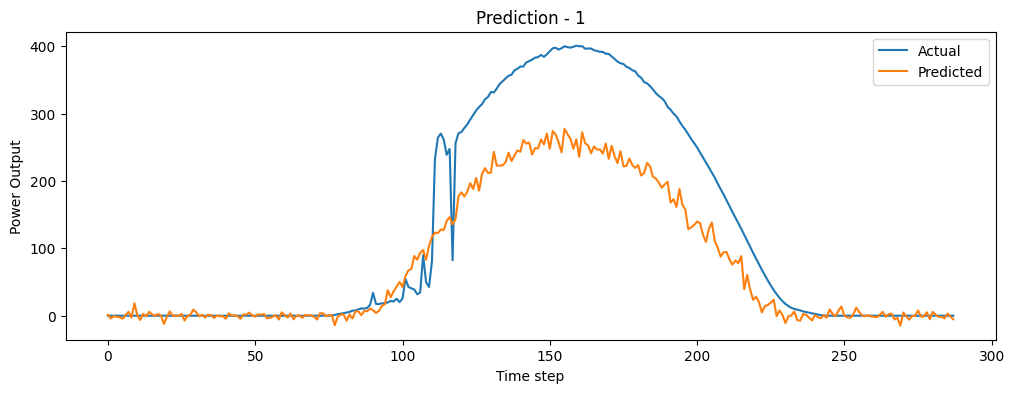

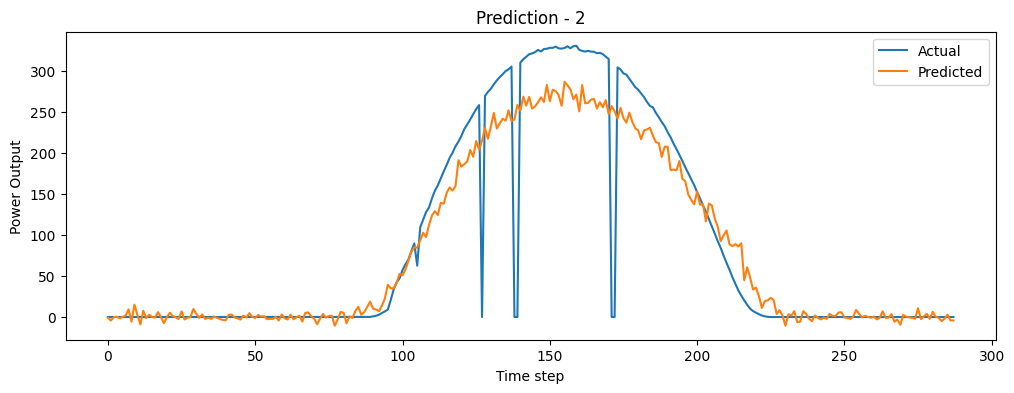

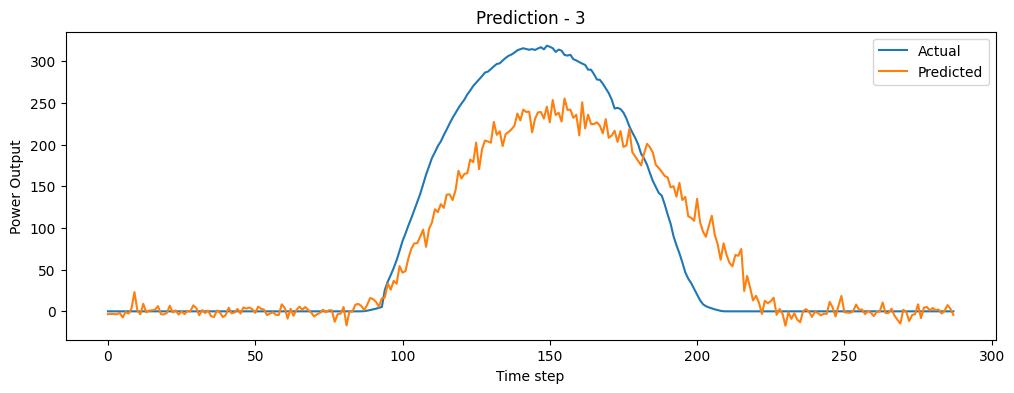

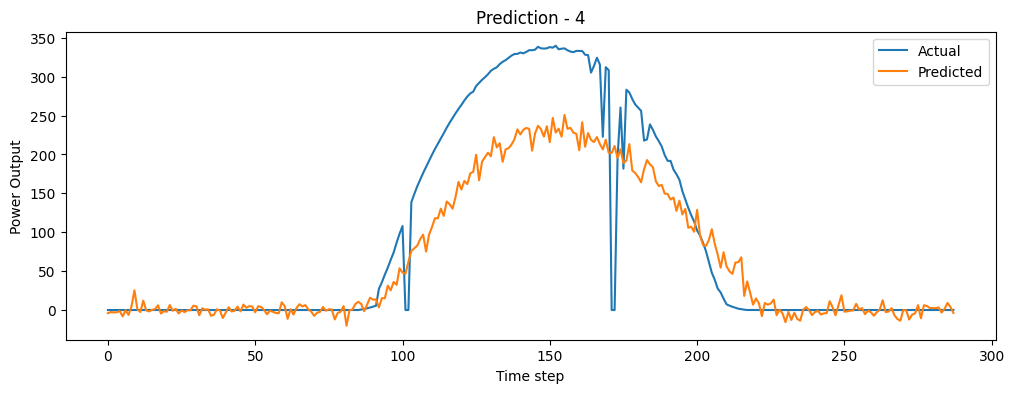

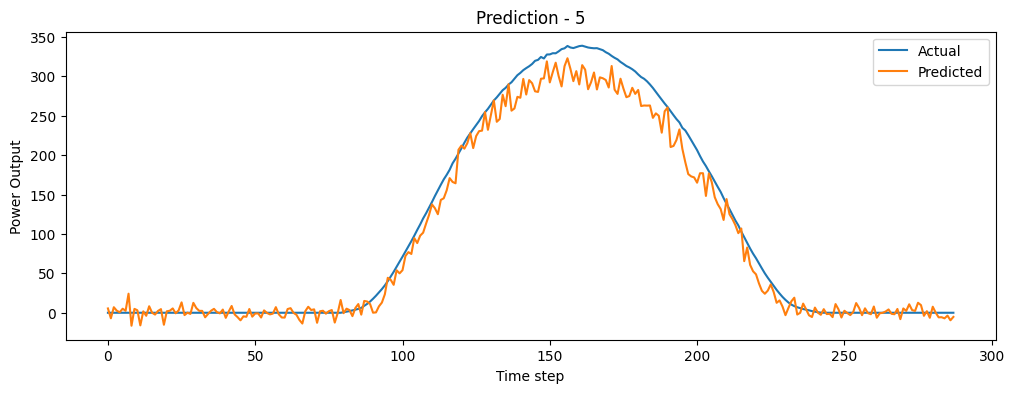

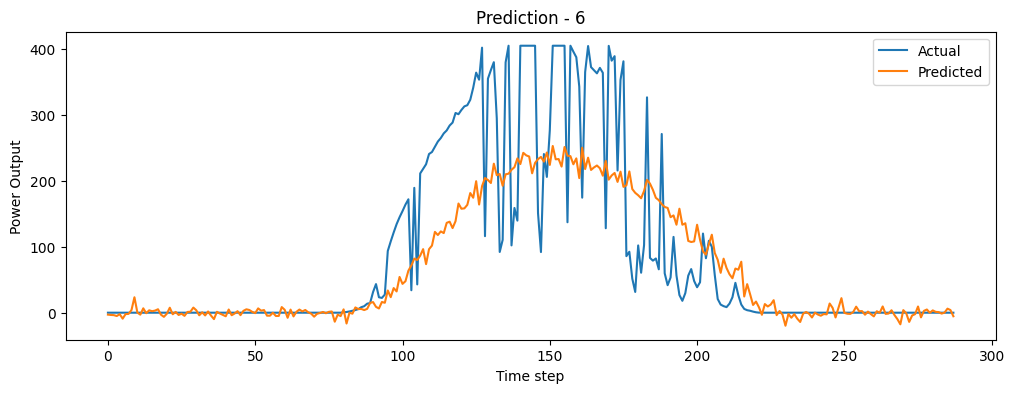

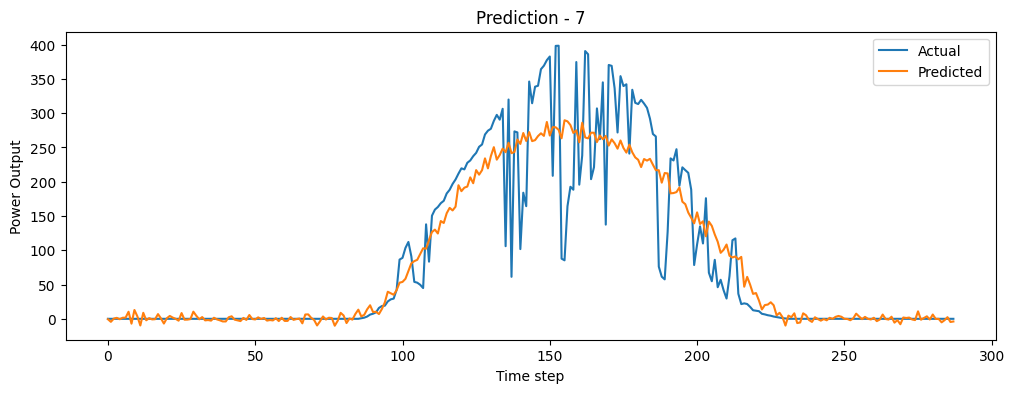

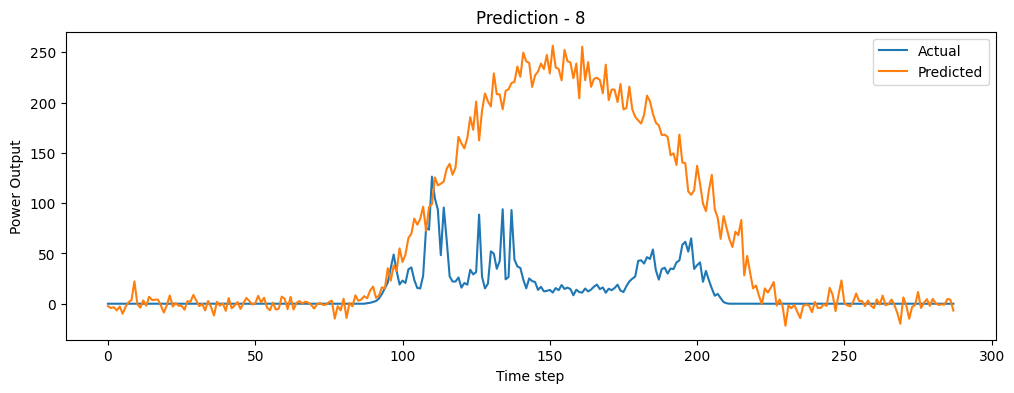

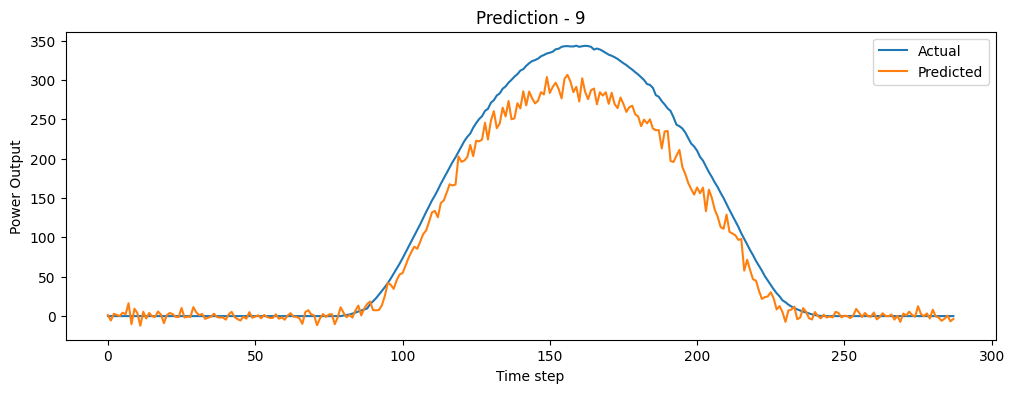

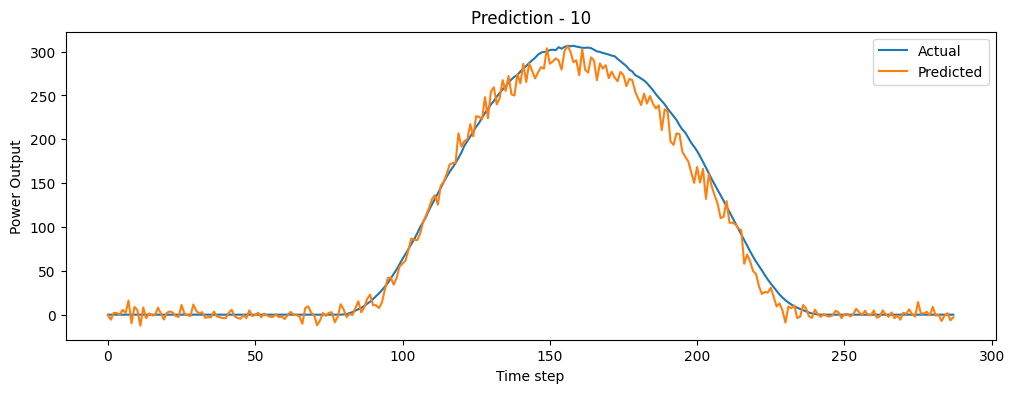

In [16]:
for i in range (10):
  plt.figure(figsize=(12, 4))
  plt.plot(y_val_inv[i], label="Actual")
  plt.plot(y_pred_inv[i], label="Predicted")
  plt.title(f"Prediction - {i+1}")
  plt.xlabel("Time step")
  plt.ylabel("Power Output")
  plt.legend()
  # plt.grid(True)
  # plot_path = f"/content/drive/MyDrive/Thesis/model/BiLSTM/validation/prediction_{i+1}.png"
  # plt.savefig(plot_path)
  plt.show()
  plt.close()

# Generate Data for another Park

## Load Data

In [17]:
df = pd.read_csv(f"{base_dir}/data/Sarafali-CN506/final/metadata.csv")
# Create PVPark instance from DataFrame
pv_park = PVPark.from_dataframe(df)
print(pv_park.location)
print(pv_park.tilt)
print(pv_park.azimuth)
print(pv_park.nominal_capacity)

Location: 
  name: Sarafali-CN506
  latitude: 35.13
  longitude: 25.259
  altitude: 334.0
  tz: Europe/Athens
20.0
180.0
1000.0


In [18]:
# Read weather data csv
df= pd.read_csv(f"{base_dir}/data/Sarafali-CN506/final/data.csv")

# Ensure ghi is a pandas Series by selecting the column
df = get_poa(df, pv_park)
print(df.head())
print(len(df)/288)

          collect_time  temperature  wind_speed  active_power  poa_global
0  2023-11-01 00:00:00         16.8         2.9           0.0         0.0
1  2023-11-01 00:05:00         17.1         3.4           0.0         0.0
2  2023-11-01 00:10:00         16.8         2.5           0.0         0.0
3  2023-11-01 00:15:00         16.6         1.3           0.0         0.0
4  2023-11-01 00:20:00         16.4         2.1           0.0         0.0
30.0


## Scale and create test Dataset

In [19]:
# Scale all features
features = ['temperature', 'wind_speed', 'poa_global']
target = 'active_power'

df[features] = scaler_x.transform(df[features])
df[[target]] = (df[[target]] / pv_park.nominal_capacity).clip(upper=1.0)

print(df)

             collect_time  temperature  wind_speed  active_power  poa_global
0     2023-11-01 00:00:00     0.393258    0.095082           0.0         0.0
1     2023-11-01 00:05:00     0.401685    0.111475           0.0         0.0
2     2023-11-01 00:10:00     0.393258    0.081967           0.0         0.0
3     2023-11-01 00:15:00     0.387640    0.042623           0.0         0.0
4     2023-11-01 00:20:00     0.382022    0.068852           0.0         0.0
...                   ...          ...         ...           ...         ...
8635  2023-11-30 23:35:00     0.306180    0.124590           0.0         0.0
8636  2023-11-30 23:40:00     0.300562    0.095082           0.0         0.0
8637  2023-11-30 23:45:00     0.303371    0.081967           0.0         0.0
8638  2023-11-30 23:50:00     0.300562    0.068852           0.0         0.0
8639  2023-11-30 23:55:00     0.300562    0.081967           0.0         0.0

[8640 rows x 5 columns]


In [20]:
def create_aligned_sequences(data, features, target, input_len=288):
    X, y = [], []
    for i in range(0, len(data), input_len):
        x_seq = data[features].iloc[i:i+input_len].values
        y_seq = data[target].iloc[i:i+input_len].values
        X.append(x_seq)
        y.append(y_seq)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_aligned_sequences(df, features, target, input_len=288)

In [21]:
print("X:", X.shape)  # (samples, 288, 3)
print("y:", y.shape)  # (samples, 288)

X: (30, 288, 3)
y: (30, 288)


## Generate and Evaluate


In [22]:
y_pred = model.predict(X)  # shape: (num_samples, 288)

# Inverse scale
y_inv = y * pv_park.nominal_capacity
y_pred_inv = y_pred * pv_park.nominal_capacity

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


## Metrics

In [23]:
# Save evaluation metrics
metrics = {
    "test": {
        "r2": float(r2_score(y_inv.flatten(), y_pred_inv.flatten())),
        "rmse": float(np.sqrt(mean_squared_error(y_inv.flatten(), y_pred_inv.flatten()))),
        "mae": float(mean_absolute_error(y_inv.flatten(), y_pred_inv.flatten())),
    }
}

print(metrics)

# with open("/content/drive/MyDrive/Thesis/model/BiLSTM/test/metrics.json", "w") as f:
#     json.dump(metrics, f, indent=4)

{'test': {'r2': 0.5565280201002827, 'rmse': 165.89321831775763, 'mae': 99.74392116386684}}


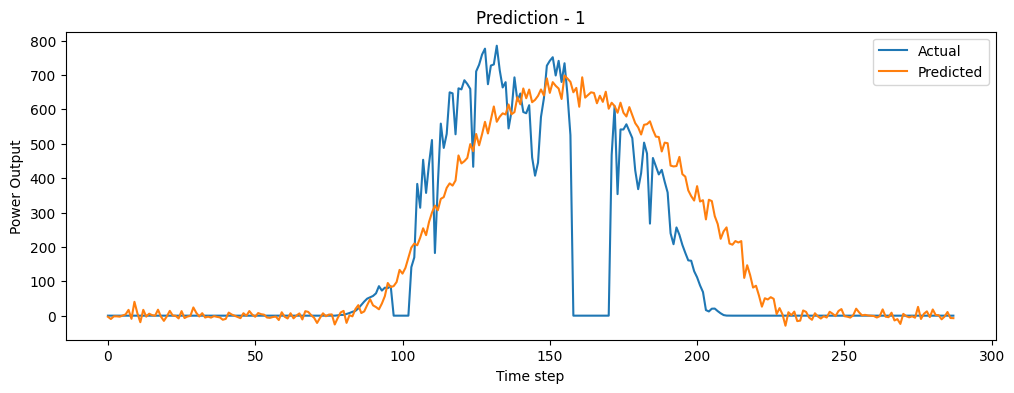

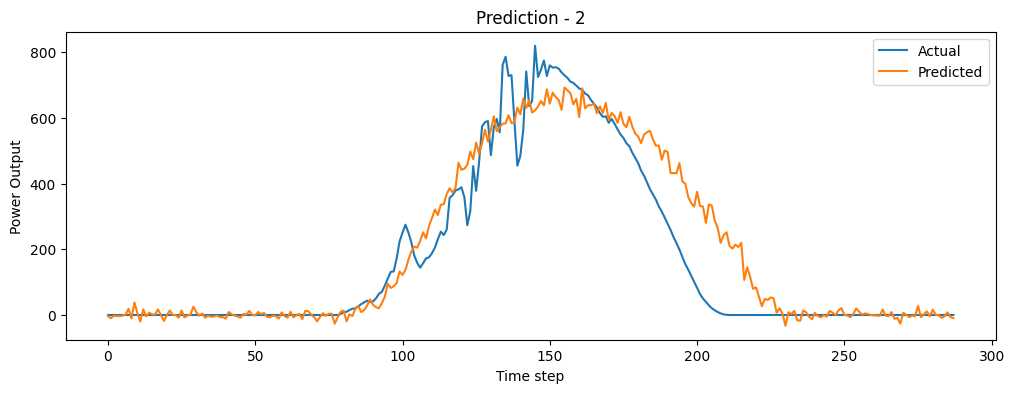

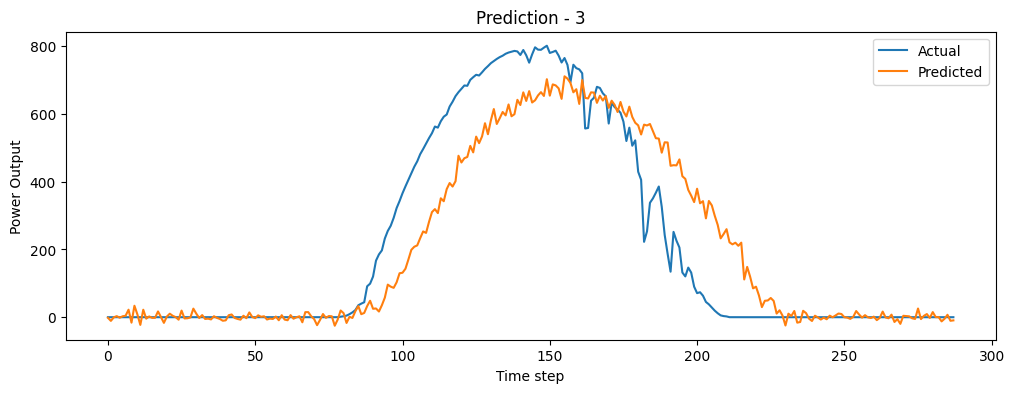

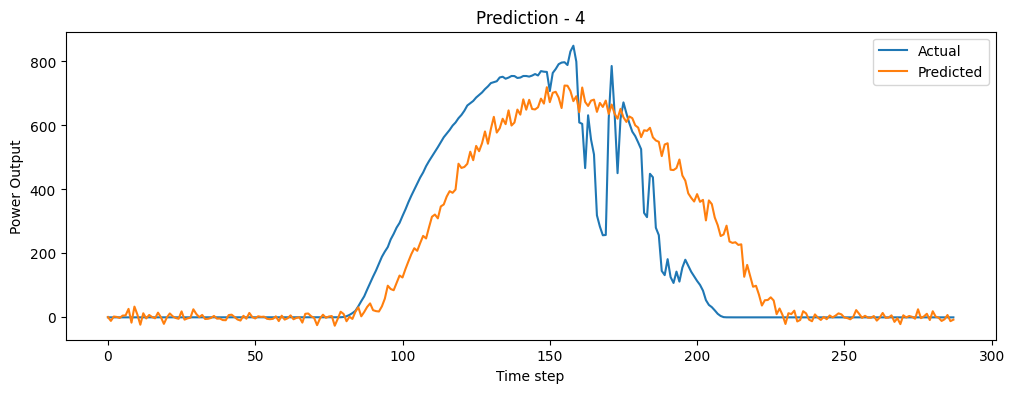

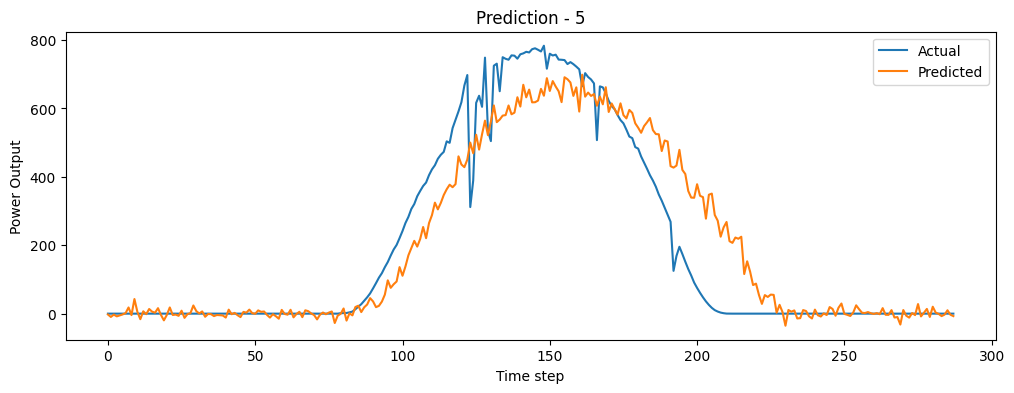

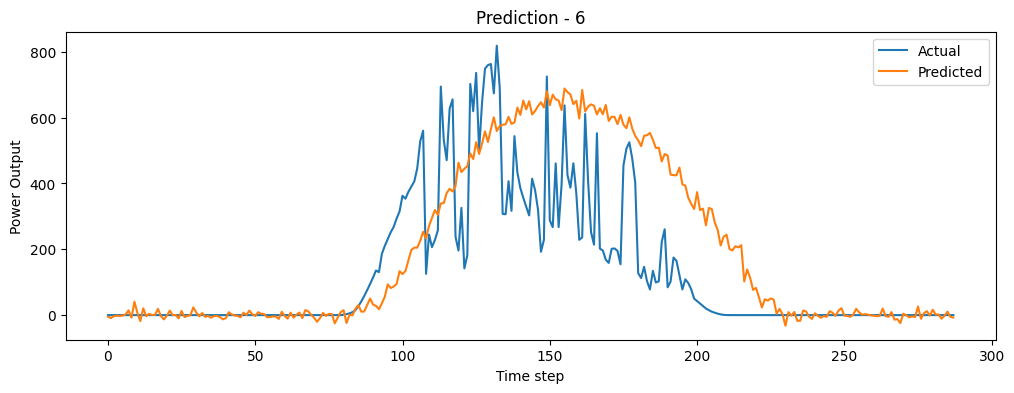

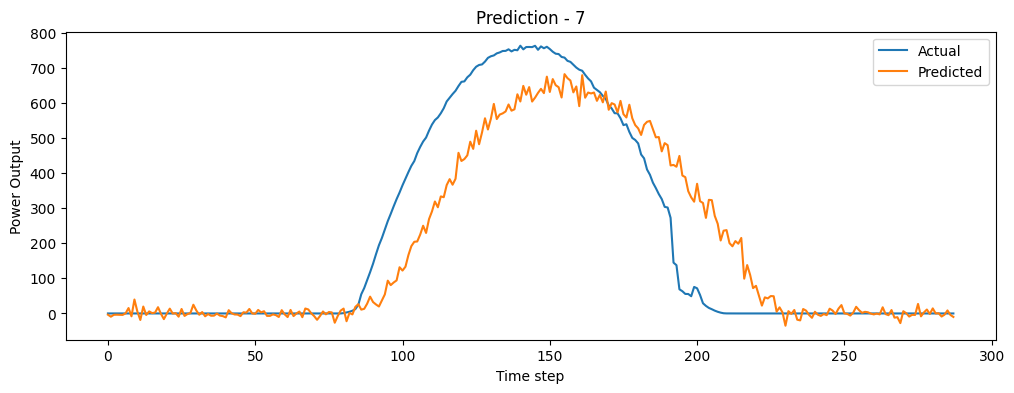

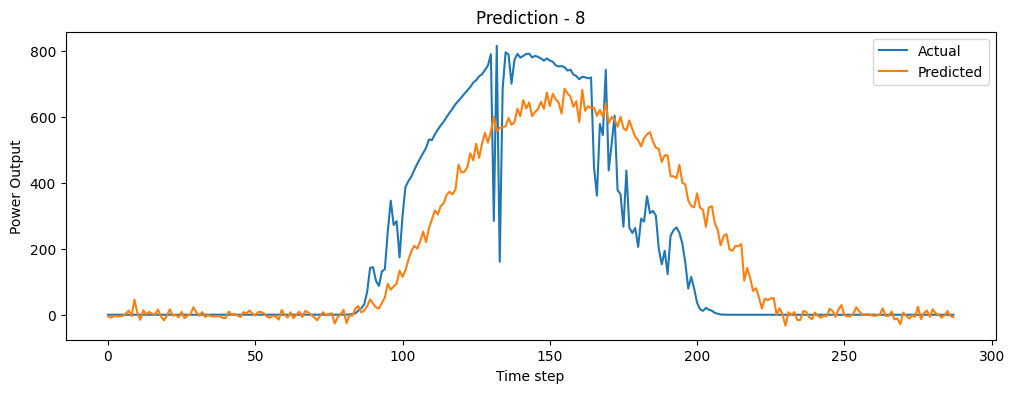

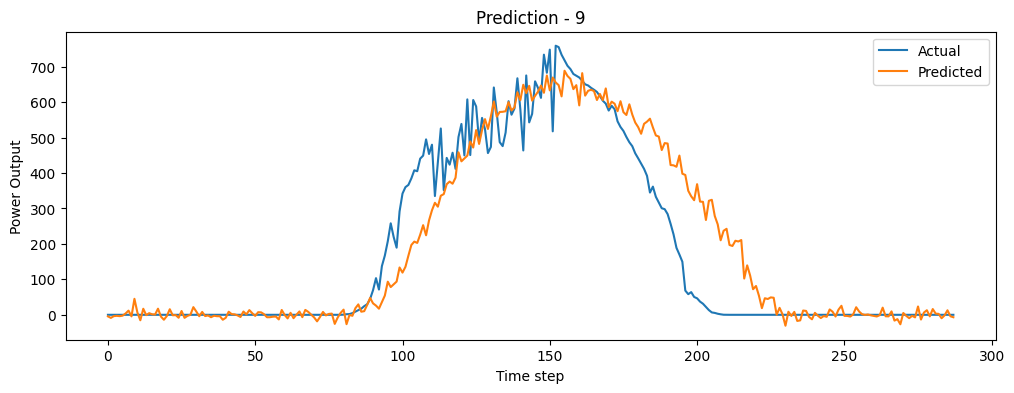

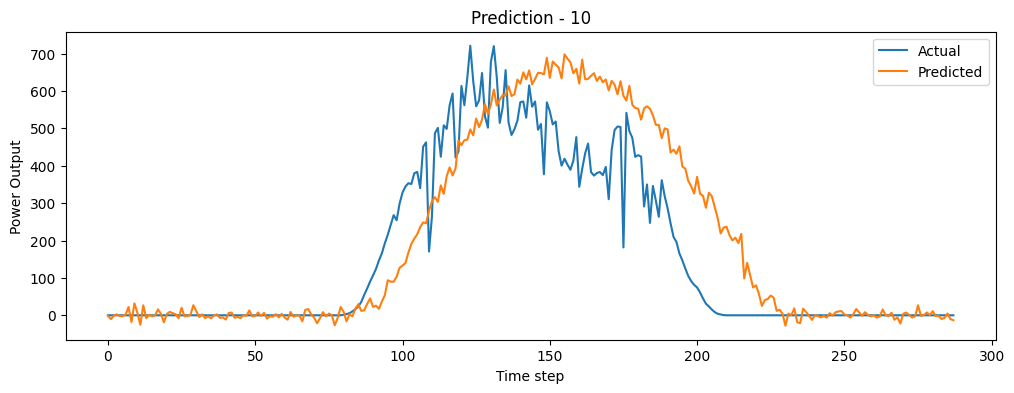

In [24]:
for i in range (10):
  plt.figure(figsize=(12, 4))
  plt.plot(y_inv[i], label="Actual")
  plt.plot(y_pred_inv[i], label="Predicted")
  plt.title(f"Prediction - {i+1}")
  plt.xlabel("Time step")
  plt.ylabel("Power Output")
  plt.legend()
  # plt.grid(True)
  # plot_path = f"/content/drive/MyDrive/Thesis/model/BiLSTM/test/prediction_{i+1}.png"
  # plt.savefig(plot_path)
  plt.show()
  plt.close()